In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.10.0)


In [4]:
!pip install spektral

     |████████████████████████████████| 112kB 6.0MB/s 


In [1]:
import numpy as np
import tensorflow as tf
import argparse
import scipy.sparse as sp
import pandas as pd 
import random
import json
import os

# from feature_matrix import FeatureMatrix

import pandas as pd 
import tensorflow_hub as hub
from bert import run_classifier
from bert import tokenization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
##Code referenced from: 
##Website Title: BERT in Keras with Tensorflow hub
##URL : https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

def create_tokenizer_from_hub_module():
  with tf.Graph().as_default():
    bert_module = hub.Module("https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1")
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])

  return tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [3]:
def split_data():

  random.seed(1)
  yTrain =  label_zip[:]
  yVal =  label_zip[:]
  yTest =  label_zip[:]
  train_mask = [False] * len(yTrain)
  val_mask = [False] * len(yTrain)
  test_mask = [False] * len(yTrain)
  n = len(yTrain)

  set_of_records_range = set(range(n))

  train_range = set(random.sample(set_of_records_range, k=int(n * 0.6)))
  set_of_records_range = set_of_records_range - train_range

  val_range = set(random.sample(set_of_records_range, k=int(n * 0.2)))
  set_of_records_range = set_of_records_range - train_range

  test_range = set(random.sample(set_of_records_range, k=int(n * 0.2)))

  for i in train_range:
      yVal[i] = (0,0)
      yTest[i] = (0,0)
      train_mask[i] = True
  for i in val_range:
      yTrain[i] = (0,0)
      yTest[i] = (0,0)
      val_mask[i] = True
  for i in test_range:
      yVal[i] = (0,0)
      yTrain[i] = (0,0)
      test_mask[i] = True

  return yTrain, yVal, yTest, train_mask, val_mask, test_mask


In [4]:
def preprocess_features(features):
  sum = np.array(features.sum(1))
  r_inv = np.power(sum, -1, dtype=float).flatten()
  r_inv[np.isinf(r_inv)] = 0.
  r_mat_inv = sp.diags(r_inv)
  features = r_mat_inv.dot(features)
  return features.todense()

In [5]:
global label_zip
path = "/content/drive/MyDrive/Colab_Notebooks/DL_final/BuzzFeed/"
data_list = []
for subfolder in ["FakeNewsContent", "RealNewsContent"]:
  print("Getting data from subfolder: ", subfolder)
  file_array = [f for f in os.listdir(path + "/" + subfolder) if f.endswith('.json')]
  file_array.sort() # file is sorted list
  file_array = [os.path.join(path + "/" + subfolder, name) for name in file_array]

  for file in file_array:
    # print("file: ", file)
    # print("path: ",path + folder + "/" + subfolder)
    with open(file, 'r') as json_file:
      data = json.load(json_file)
      if file.split("/")[-2] == "FakeNewsContent":
          data_list.append([data['text'], 1])
      else:
          data_list.append([data['text'], 0])

print("Creating data frame")
data_frame = pd.DataFrame(data_list, columns=["text", "label"])
# data_frame = data_frame.sample(frac=1)

input = data_frame.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                       text_a=x['text'], text_b=None, label=x['label']), axis=1)
print(data_frame)
print("extracting features")
tokenizer = create_tokenizer_from_hub_module()
features = run_classifier.convert_examples_to_features(input, [0, 1], 128, tokenizer)

train_features_list = []
for item in features:
  temp = item.input_ids
  temp.append(item.label_id)
  train_features_list.append(temp)
column_names = ["feature" + str(i) for i in range(128)]
column_names.append("label")
features_frame = pd.DataFrame(train_features_list, columns=column_names)  ##extracted features data frame
# /content/drive/MyDrive/Colab_Notebooks/DL_final/BuzzFeed/FakeNewsContent/BuzzFeed_Fake_3-Webpage.json

label = features_frame['label'].tolist()
label_comp = [0 if each else 1 for each in label]

label_zip = list(zip(label_comp, label))
features_frame.drop(['label'], axis=1)
feature_np = features_frame.values

Getting data from subfolder:  FakeNewsContent
Getting data from subfolder:  RealNewsContent
Creating data frame
                                                  text  label
0    I woke up this morning to find a variation of ...      1
1    Former President Bill Clinton and his Clinton ...      1
2    After collapsing just before trying to step in...      1
3    Donald Trump is, well, deplorable. He’s sugges...      1
4                      Website is Down For Maintenance      1
..                                                 ...    ...
177  Like much of the mainstream media, the Washing...      0
178  2016 Obama’s team isn’t laughing at Trump anym...      0
179  Story highlights Trump has 45%, Clinton 42% an...      0
180  There may be a few women out there who enjoy a...      0
181  Off Message Is Donald Trump qualified to be pr...      0

[182 rows x 2 columns]
extracting features
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i woke up this morning to find a variation of this headline splashed all over my news feed : bill clinton : ‘ natural ’ for foundation donors to seek favors here ’ s google : naturally , my reaction was “ oh , s * * t , what did bill clinton do to damage his wife ’ s campaign now ? ” of course , the headline sounds really , really awful . it plays right into the idea that the clinton foundation is all about pay to play , just like donald trump has been saying all along . unfortunately , it takes reading beyond the headlines , which is something most people don ’ t do , to find out the real [SEP]


INFO:tensorflow:tokens: [CLS] i woke up this morning to find a variation of this headline splashed all over my news feed : bill clinton : ‘ natural ’ for foundation donors to seek favors here ’ s google : naturally , my reaction was “ oh , s * * t , what did bill clinton do to damage his wife ’ s campaign now ? ” of course , the headline sounds really , really awful . it plays right into the idea that the clinton foundation is all about pay to play , just like donald trump has been saying all along . unfortunately , it takes reading beyond the headlines , which is something most people don ’ t do , to find out the real [SEP]


INFO:tensorflow:input_ids: 101 1045 8271 2039 2023 2851 2000 2424 1037 8386 1997 2023 17653 22055 2035 2058 2026 2739 5438 1024 3021 7207 1024 1520 3019 1521 2005 3192 17843 2000 6148 21191 2182 1521 1055 8224 1024 8100 1010 2026 4668 2001 1523 2821 1010 1055 1008 1008 1056 1010 2054 2106 3021 7207 2079 2000 4053 2010 2564 1521 1055 3049 2085 1029 1524 1997 2607 1010 1996 17653 4165 2428 1010 2428 9643 1012 2009 3248 2157 2046 1996 2801 2008 1996 7207 3192 2003 2035 2055 3477 2000 2377 1010 2074 2066 6221 8398 2038 2042 3038 2035 2247 1012 6854 1010 2009 3138 3752 3458 1996 19377 1010 2029 2003 2242 2087 2111 2123 1521 1056 2079 1010 2000 2424 2041 1996 2613 102


INFO:tensorflow:input_ids: 101 1045 8271 2039 2023 2851 2000 2424 1037 8386 1997 2023 17653 22055 2035 2058 2026 2739 5438 1024 3021 7207 1024 1520 3019 1521 2005 3192 17843 2000 6148 21191 2182 1521 1055 8224 1024 8100 1010 2026 4668 2001 1523 2821 1010 1055 1008 1008 1056 1010 2054 2106 3021 7207 2079 2000 4053 2010 2564 1521 1055 3049 2085 1029 1524 1997 2607 1010 1996 17653 4165 2428 1010 2428 9643 1012 2009 3248 2157 2046 1996 2801 2008 1996 7207 3192 2003 2035 2055 3477 2000 2377 1010 2074 2066 6221 8398 2038 2042 3038 2035 2247 1012 6854 1010 2009 3138 3752 3458 1996 19377 1010 2029 2003 2242 2087 2111 2123 1521 1056 2079 1010 2000 2424 2041 1996 2613 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] former president bill clinton and his clinton health access initiative ( cha ##i ) distributed “ watered - down ” hiv / aids drugs to patients in sub - saharan africa , and “ likely increased ” the risks of mor ##bid ##ity and mortality , according to a draft congressional report obtained by the daily caller news foundation . the congressional report , titled , “ the clinton foundation and the india success story , ” was initiated by rep . marsh ##a blackburn , a tennessee republican and vice - chair of the house energy and commerce committee . the cha ##i program to help aids victims is considered one of the clinton foundation ’ s most important contributions and is probably its best [SEP]


INFO:tensorflow:tokens: [CLS] former president bill clinton and his clinton health access initiative ( cha ##i ) distributed “ watered - down ” hiv / aids drugs to patients in sub - saharan africa , and “ likely increased ” the risks of mor ##bid ##ity and mortality , according to a draft congressional report obtained by the daily caller news foundation . the congressional report , titled , “ the clinton foundation and the india success story , ” was initiated by rep . marsh ##a blackburn , a tennessee republican and vice - chair of the house energy and commerce committee . the cha ##i program to help aids victims is considered one of the clinton foundation ’ s most important contributions and is probably its best [SEP]


INFO:tensorflow:input_ids: 101 2280 2343 3021 7207 1998 2010 7207 2740 3229 6349 1006 15775 2072 1007 5500 1523 27129 1011 2091 1524 9820 1013 8387 5850 2000 5022 1999 4942 1011 24505 3088 1010 1998 1523 3497 3445 1524 1996 10831 1997 22822 17062 3012 1998 13356 1010 2429 2000 1037 4433 7740 3189 4663 2011 1996 3679 20587 2739 3192 1012 1996 7740 3189 1010 4159 1010 1523 1996 7207 3192 1998 1996 2634 3112 2466 1010 1524 2001 7531 2011 16360 1012 9409 2050 13934 1010 1037 5298 3951 1998 3580 1011 3242 1997 1996 2160 2943 1998 6236 2837 1012 1996 15775 2072 2565 2000 2393 8387 5694 2003 2641 2028 1997 1996 7207 3192 1521 1055 2087 2590 5857 1998 2003 2763 2049 2190 102


INFO:tensorflow:input_ids: 101 2280 2343 3021 7207 1998 2010 7207 2740 3229 6349 1006 15775 2072 1007 5500 1523 27129 1011 2091 1524 9820 1013 8387 5850 2000 5022 1999 4942 1011 24505 3088 1010 1998 1523 3497 3445 1524 1996 10831 1997 22822 17062 3012 1998 13356 1010 2429 2000 1037 4433 7740 3189 4663 2011 1996 3679 20587 2739 3192 1012 1996 7740 3189 1010 4159 1010 1523 1996 7207 3192 1998 1996 2634 3112 2466 1010 1524 2001 7531 2011 16360 1012 9409 2050 13934 1010 1037 5298 3951 1998 3580 1011 3242 1997 1996 2160 2943 1998 6236 2837 1012 1996 15775 2072 2565 2000 2393 8387 5694 2003 2641 2028 1997 1996 7207 3192 1521 1055 2087 2590 5857 1998 2003 2763 2049 2190 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] after collapsing just before trying to step into her van after being removed from the 9 - 11 ceremony in new york city , hillary clinton emerged from her daughter ’ s apartment seeming like a new person . too new to be believed as a matter of fact , since the hillary at chelsea clinton ’ s apartment was noticeably well and energetic . even more unbelievable was the difference in appearance such as her being many pounds lighter , more vibrant , and apparently having a sort of drive through type rhino ##pl ##ast ##y pre ##formed in the short amount of time she was in the apartment . the nose on the hillary clinton double at the apartment is clearly different than all [SEP]


INFO:tensorflow:tokens: [CLS] after collapsing just before trying to step into her van after being removed from the 9 - 11 ceremony in new york city , hillary clinton emerged from her daughter ’ s apartment seeming like a new person . too new to be believed as a matter of fact , since the hillary at chelsea clinton ’ s apartment was noticeably well and energetic . even more unbelievable was the difference in appearance such as her being many pounds lighter , more vibrant , and apparently having a sort of drive through type rhino ##pl ##ast ##y pre ##formed in the short amount of time she was in the apartment . the nose on the hillary clinton double at the apartment is clearly different than all [SEP]


INFO:tensorflow:input_ids: 101 2044 22724 2074 2077 2667 2000 3357 2046 2014 3158 2044 2108 3718 2013 1996 1023 1011 2340 5103 1999 2047 2259 2103 1010 18520 7207 6003 2013 2014 2684 1521 1055 4545 16064 2066 1037 2047 2711 1012 2205 2047 2000 2022 3373 2004 1037 3043 1997 2755 1010 2144 1996 18520 2012 9295 7207 1521 1055 4545 2001 25327 2092 1998 18114 1012 2130 2062 23653 2001 1996 4489 1999 3311 2107 2004 2014 2108 2116 7038 9442 1010 2062 17026 1010 1998 4593 2383 1037 4066 1997 3298 2083 2828 24091 24759 14083 2100 3653 29021 1999 1996 2460 3815 1997 2051 2016 2001 1999 1996 4545 1012 1996 4451 2006 1996 18520 7207 3313 2012 1996 4545 2003 4415 2367 2084 2035 102


INFO:tensorflow:input_ids: 101 2044 22724 2074 2077 2667 2000 3357 2046 2014 3158 2044 2108 3718 2013 1996 1023 1011 2340 5103 1999 2047 2259 2103 1010 18520 7207 6003 2013 2014 2684 1521 1055 4545 16064 2066 1037 2047 2711 1012 2205 2047 2000 2022 3373 2004 1037 3043 1997 2755 1010 2144 1996 18520 2012 9295 7207 1521 1055 4545 2001 25327 2092 1998 18114 1012 2130 2062 23653 2001 1996 4489 1999 3311 2107 2004 2014 2108 2116 7038 9442 1010 2062 17026 1010 1998 4593 2383 1037 4066 1997 3298 2083 2828 24091 24759 14083 2100 3653 29021 1999 1996 2460 3815 1997 2051 2016 2001 1999 1996 4545 1012 1996 4451 2006 1996 18520 7207 3313 2012 1996 4545 2003 4415 2367 2084 2035 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] donald trump is , well , de ##pl ##ora ##ble . he ’ s suggested building a wall to keep invading horde ##s of brown - skinned “ rap ##ists ” and “ drug dealers ” from charging into the country , gotten on board with creating a national registry for muslims like hitler did with the jews , forcing said muslims to wear special identification badges , and even rounding them up into modern - day concentration camps as a “ temporary measure . ” he ’ s even suggested outright murdering the families of terrorists abroad : “ the other thing with the terrorists is you have to take out their families , when you get these terrorists , you have to take out [SEP]


INFO:tensorflow:tokens: [CLS] donald trump is , well , de ##pl ##ora ##ble . he ’ s suggested building a wall to keep invading horde ##s of brown - skinned “ rap ##ists ” and “ drug dealers ” from charging into the country , gotten on board with creating a national registry for muslims like hitler did with the jews , forcing said muslims to wear special identification badges , and even rounding them up into modern - day concentration camps as a “ temporary measure . ” he ’ s even suggested outright murdering the families of terrorists abroad : “ the other thing with the terrorists is you have to take out their families , when you get these terrorists , you have to take out [SEP]


INFO:tensorflow:input_ids: 101 6221 8398 2003 1010 2092 1010 2139 24759 6525 3468 1012 2002 1521 1055 4081 2311 1037 2813 2000 2562 17657 21038 2015 1997 2829 1011 19937 1523 9680 5130 1524 1998 1523 4319 16743 1524 2013 13003 2046 1996 2406 1010 5407 2006 2604 2007 4526 1037 2120 15584 2005 7486 2066 8042 2106 2007 1996 5181 1010 6932 2056 7486 2000 4929 2569 8720 23433 1010 1998 2130 26939 2068 2039 2046 2715 1011 2154 6693 7958 2004 1037 1523 5741 5468 1012 1524 2002 1521 1055 2130 4081 13848 21054 1996 2945 1997 15554 6917 1024 1523 1996 2060 2518 2007 1996 15554 2003 2017 2031 2000 2202 2041 2037 2945 1010 2043 2017 2131 2122 15554 1010 2017 2031 2000 2202 2041 102


INFO:tensorflow:input_ids: 101 6221 8398 2003 1010 2092 1010 2139 24759 6525 3468 1012 2002 1521 1055 4081 2311 1037 2813 2000 2562 17657 21038 2015 1997 2829 1011 19937 1523 9680 5130 1524 1998 1523 4319 16743 1524 2013 13003 2046 1996 2406 1010 5407 2006 2604 2007 4526 1037 2120 15584 2005 7486 2066 8042 2106 2007 1996 5181 1010 6932 2056 7486 2000 4929 2569 8720 23433 1010 1998 2130 26939 2068 2039 2046 2715 1011 2154 6693 7958 2004 1037 1523 5741 5468 1012 1524 2002 1521 1055 2130 4081 13848 21054 1996 2945 1997 15554 6917 1024 1523 1996 2060 2518 2007 1996 15554 2003 2017 2031 2000 2202 2041 2037 2945 1010 2043 2017 2131 2122 15554 1010 2017 2031 2000 2202 2041 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] website is down for maintenance [SEP]


INFO:tensorflow:tokens: [CLS] website is down for maintenance [SEP]


INFO:tensorflow:input_ids: 101 4037 2003 2091 2005 6032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4037 2003 2091 2005 6032 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [6]:
features =  sp.csr_matrix(feature_np, dtype=float).tolil()
adj =  pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/DL_final/news_news_bf_adjacency_matrix.csv", header=None).values
y_train, y_val, y_test, train_mask, val_mask, test_mask =  split_data()

features=sp.csr_matrix(features)

print(features)
features = preprocess_features(features)



label_encoder = LabelEncoder()
label = label_encoder.fit_transform(label)
label = tf.keras.utils.to_categorical(label)
classes = label_encoder.classes_

  (0, 0)	101.0
  (0, 1)	1045.0
  (0, 2)	8271.0
  (0, 3)	2039.0
  (0, 4)	2023.0
  (0, 5)	2851.0
  (0, 6)	2000.0
  (0, 7)	2424.0
  (0, 8)	1037.0
  (0, 9)	8386.0
  (0, 10)	1997.0
  (0, 11)	2023.0
  (0, 12)	17653.0
  (0, 13)	22055.0
  (0, 14)	2035.0
  (0, 15)	2058.0
  (0, 16)	2026.0
  (0, 17)	2739.0
  (0, 18)	5438.0
  (0, 19)	1024.0
  (0, 20)	3021.0
  (0, 21)	7207.0
  (0, 22)	1024.0
  (0, 23)	1520.0
  (0, 24)	3019.0
  :	:
  (181, 103)	2466.0
  (181, 104)	2506.0
  (181, 105)	2917.0
  (181, 106)	3398.0
  (181, 107)	1010.0
  (181, 108)	3398.0
  (181, 109)	1010.0
  (181, 110)	3398.0
  (181, 111)	1010.0
  (181, 112)	2009.0
  (181, 113)	1521.0
  (181, 114)	1055.0
  (181, 115)	1037.0
  (181, 116)	2502.0
  (181, 117)	2305.0
  (181, 118)	2005.0
  (181, 119)	18520.0
  (181, 120)	7207.0
  (181, 121)	2205.0
  (181, 122)	1012.0
  (181, 123)	2016.0
  (181, 124)	1521.0
  (181, 125)	1055.0
  (181, 126)	2288.0
  (181, 127)	102.0


In [ ]:
# print(label)

In [8]:
y_train  = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
train_mask  = np.asarray(train_mask)
val_mask  = np.asarray(val_mask)
test_mask  = np.asarray(test_mask)
label = np.asarray(label)

In [9]:
# np.isnan(y_train.data).any()
# np.isnan(y_val.data).any()
np.isnan(y_test.data).any()

False

In [10]:
train_mask.shape

(182,)

In [11]:
from __future__ import division
from __future__ import print_function
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
import time
import tensorflow as tf 
from spektral.layers import GCNConv, GATConv, AGNNConv
# from  utils import *
# from models import GCN, MLP

# Set random seed
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

epochs = 25
dropout = 0.3
weight_decay = 2e-5
early_stopping = 10
learning_rate = 5e-3
num_nodes = features.shape[0]
# num_nodes = adj.shape[0]
l2_reg = 5e-6
num_classes = 2
# 'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),


In [12]:
features.shape[1]

129

##GCN1

In [40]:
adj_matrix = GCNConv.preprocess(adj).astype('f4')
adj_matrix[np.isinf(adj_matrix)] = 1

In [41]:

x_inputs = Input(shape = features.shape[1])
a_inputs = Input((num_nodes,), sparse=True, dtype=tf.float32)
do_1 = Dropout(dropout)(x_inputs)
gc_1 = GCNConv(16,
               activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=False)([do_1, a_inputs])
 
do_2 = Dropout(dropout)(gc_1)
gc_2 = GCNConv(16,
               activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=False)([do_2, a_inputs])
 
output =  Dense(units=num_classes, activation='softmax')(gc_2)
model = Model(inputs=[x_inputs, a_inputs], outputs=output)
optimizer = Adam(lr=learning_rate,clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',#binary_crossentropy
              weighted_metrics=['acc'])
model.summary()



Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 129)]        0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 129)          0           input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 182)]        0                                            
__________________________________________________________________________________________________
gcn_conv_4 (GCNConv)            (None, 16)           2064        dropout_10[0][0]                 
                                                                 input_12[0][0]       

In [43]:
# Train model
validation_data = ([features, adj_matrix], label, val_mask)
history = model.fit([features, adj_matrix],
          label,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=num_nodes,
          validation_data=validation_data,
          shuffle=False,
          ) 


Epoch 1/25
1/1 [==============================] - 0s 58ms/step - loss: 0.4108 - acc: 0.5138 - val_loss: 0.1330 - val_acc: 0.4444
Epoch 2/25
1/1 [==============================] - 0s 18ms/step - loss: 0.4110 - acc: 0.5229 - val_loss: 0.1328 - val_acc: 0.5000
Epoch 3/25
1/1 [==============================] - 0s 19ms/step - loss: 0.4098 - acc: 0.5321 - val_loss: 0.1327 - val_acc: 0.5000
Epoch 4/25
1/1 [==============================] - 0s 18ms/step - loss: 0.4099 - acc: 0.5413 - val_loss: 0.1325 - val_acc: 0.5000
Epoch 5/25
1/1 [==============================] - 0s 18ms/step - loss: 0.4097 - acc: 0.5321 - val_loss: 0.1324 - val_acc: 0.5000
Epoch 6/25
1/1 [==============================] - 0s 19ms/step - loss: 0.4103 - acc: 0.5413 - val_loss: 0.1323 - val_acc: 0.5000
Epoch 7/25
1/1 [==============================] - 0s 19ms/step - loss: 0.4079 - acc: 0.5780 - val_loss: 0.1323 - val_acc: 0.5000
Epoch 8/25
1/1 [==============================] - 0s 19ms/step - loss: 0.4066 - acc: 0.6881 - val

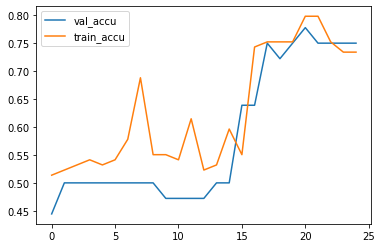

In [44]:
import matplotlib 
from matplotlib import pyplot
pyplot.plot(history.history['val_acc'], label='val_accu')
pyplot.plot(history.history['acc'],label = 'train_accu') 

pyplot.legend()

In [45]:
max(history.history['val_acc'])

0.7777777910232544

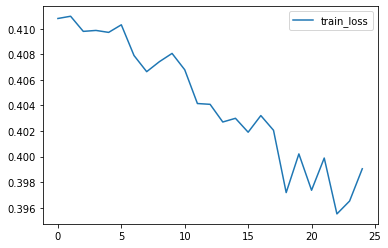

In [47]:

pyplot.plot(history.history['loss'],label = 'train_loss') 
 
pyplot.legend()

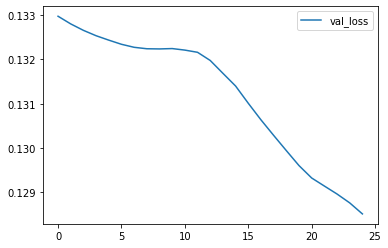

In [48]:

pyplot.plot(history.history['val_loss'], label='val_loss')

pyplot.legend()

##GAT

In [60]:
adj_matrix = GATConv.preprocess(adj).astype('f4')
adj_matrix[np.isinf(adj_matrix)] = 1

In [61]:
x_inputs = Input(shape = features.shape[1])
a_inputs = Input((num_nodes,), sparse=True, dtype=tf.float32)

do_1 = Dropout(dropout)(x_inputs)
gc_1 = GATConv(12,
               attn_heads=8,
               concat_heads=True,
               dropout_rate=dropout,
               activation='elu',
               kernel_regularizer=l2(l2_reg),
               attn_kernel_regularizer=l2(l2_reg)
               )([do_1, a_inputs])
do_2 = Dropout(dropout)(gc_1)
gc_2 = GATConv(num_classes,
               attn_heads=1,
               concat_heads=False,
               dropout_rate=dropout,
               activation='elu',
               kernel_regularizer=l2(l2_reg),
               attn_kernel_regularizer=l2(l2_reg)
               )([do_2, a_inputs])
output =  Dense(units=num_classes, activation='softmax')(gc_2)

In [62]:
model = Model(inputs=[x_inputs, a_inputs], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 129)]        0                                            
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 129)          0           input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 182)]        0                                            
__________________________________________________________________________________________________
gat_conv_8 (GATConv)            (None, 96)           12576       dropout_14[0][0]                 
                                                                 input_16[0][0]       

In [63]:
validation_data = ([features, adj_matrix], label, val_mask)
history1 = model.fit([features, adj_matrix],
          label,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=num_nodes,
          validation_data=validation_data,
          shuffle=False
          )

Epoch 1/25
1/1 [==============================] - 0s 246ms/step - loss: 0.4152 - acc: 0.5138 - val_loss: 0.1375 - val_acc: 0.4444
Epoch 2/25
1/1 [==============================] - 0s 23ms/step - loss: 0.4150 - acc: 0.5138 - val_loss: 0.1377 - val_acc: 0.4444
Epoch 3/25
1/1 [==============================] - 0s 23ms/step - loss: 0.4147 - acc: 0.5138 - val_loss: 0.1378 - val_acc: 0.4444
Epoch 4/25
1/1 [==============================] - 0s 23ms/step - loss: 0.4142 - acc: 0.5138 - val_loss: 0.1378 - val_acc: 0.4444
Epoch 5/25
1/1 [==============================] - 0s 25ms/step - loss: 0.4142 - acc: 0.5138 - val_loss: 0.1378 - val_acc: 0.4444
Epoch 6/25
1/1 [==============================] - 0s 24ms/step - loss: 0.4142 - acc: 0.5138 - val_loss: 0.1377 - val_acc: 0.4444
Epoch 7/25
1/1 [==============================] - 0s 24ms/step - loss: 0.4131 - acc: 0.5138 - val_loss: 0.1375 - val_acc: 0.4444
Epoch 8/25
1/1 [==============================] - 0s 23ms/step - loss: 0.4127 - acc: 0.5138 - va

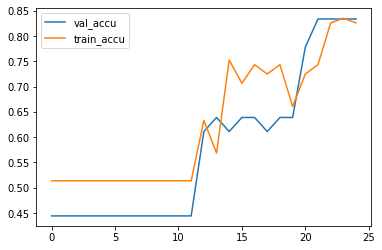

In [64]:
import matplotlib 
from matplotlib import pyplot
pyplot.plot(history1.history['val_acc'], label='val_accu')
pyplot.plot(history1.history['acc'],label = 'train_accu') 

pyplot.legend()

In [66]:
max(history1.history['val_acc'])

0.8333333134651184

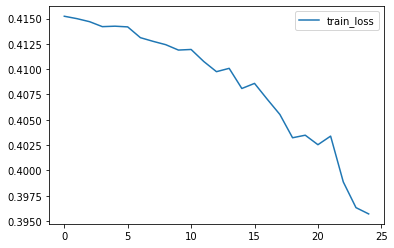

In [67]:

pyplot.plot(history1.history['loss'],label = 'train_loss') 
 
pyplot.legend()

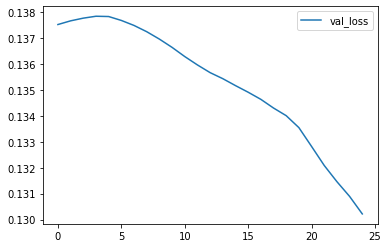

In [68]:

pyplot.plot(history1.history['val_loss'], label='val_loss')

pyplot.legend()

##References
GCN:
Topic: Training Graph Convolutional Networks on Node Classification Task
Website: https://towardsdatascience.com/graph-convolutional-networks-on-node-classification-2b6bbec1d042